In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. 데이터 로드
np.random.seed(20241212)
data = pd.read_csv("KOSPI_valuefactors_from2015to2022.csv")

Best z (0=bottom,1=top): [0 0 0 1 0]
Best theta: [0.5 0.  0.5 0.  0. ]
Training total log return (2015~2023): 1.5964343805676702
Test total log return (2015~2023): 0.8048066122109432

[Training Year-by-Year Results]
From 2016 to 2017: Log Return = 0.2591, Wealth = 129.57
From 2017 to 2018: Log Return = 0.4594, Wealth = 205.12
From 2018 to 2019: Log Return = 0.2116, Wealth = 253.46
From 2019 to 2020: Log Return = -0.0893, Wealth = 231.82
From 2020 to 2021: Log Return = 0.7313, Wealth = 481.66
From 2021 to 2022: Log Return = 0.2944, Wealth = 646.57
From 2022 to 2023: Log Return = -0.2701, Wealth = 493.54

[Testing Year-by-Year Results]
From 2016 to 2017: Log Return = 0.4027, Wealth = 149.58
From 2017 to 2018: Log Return = -0.0322, Wealth = 144.83
From 2018 to 2019: Log Return = 0.0441, Wealth = 151.36
From 2019 to 2020: Log Return = -0.1437, Wealth = 131.10
From 2020 to 2021: Log Return = 0.7827, Wealth = 286.77
From 2021 to 2022: Log Return = 0.0973, Wealth = 316.07
From 2022 to 2023: L

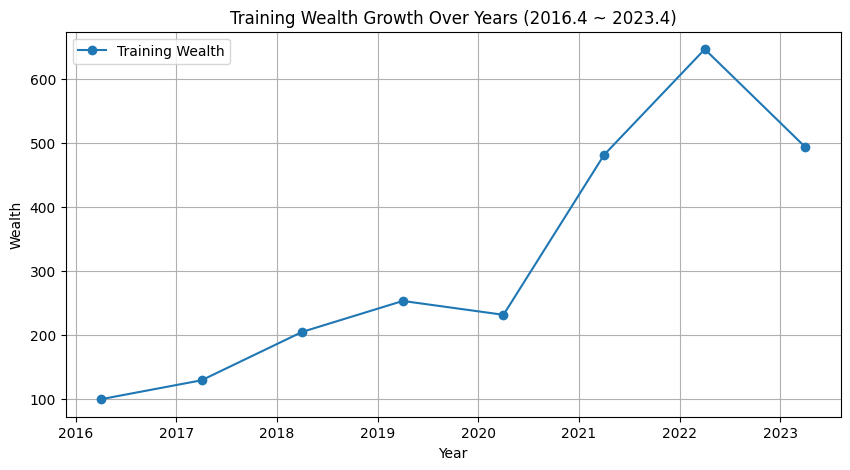

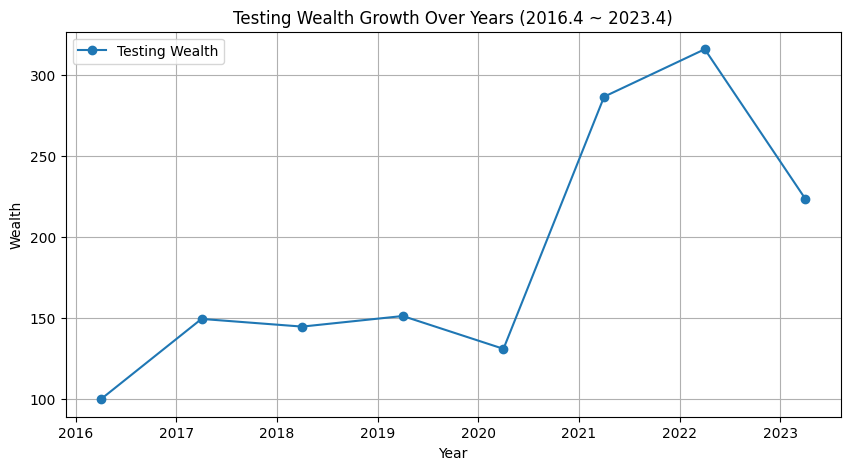

In [4]:
# 종목별 분할: 첫 150개 train, 나머지 test
train_data = data.iloc[:150].copy()
test_data = data.iloc[150:].copy()

metrics = ['PBR', 'PER', 'PSR', 'EBIT/EV', 'P_CF']
years = range(2015, 2022)  # 2015 ~ 2023년

def top_10_percent_portfolio(df, metric_year):
    df_sorted = df.sort_values(by=metric_year, ascending=False)
    n = len(df_sorted)
    top_n = int(n * 0.1)
    return df_sorted.head(top_n)

def bottom_10_percent_portfolio(df, metric_year):
    df_sorted = df.sort_values(by=metric_year, ascending=True)
    n = len(df_sorted)
    bot_n = int(n * 0.1)
    return df_sorted.head(bot_n)

# 연도별/지표별 top/bottom 성장률 계산
def calculate_growth_factors(df):
    result = {}
    for y in years:
        for m in metrics:
            metric_col = m + str(y)
            start_col = 'start_price' + str(y)
            end_col = 'end_price' + str(y)
            
            top_df = top_10_percent_portfolio(df, metric_col)
            bot_df = bottom_10_percent_portfolio(df, metric_col)
            
            top_g = (top_df[end_col] / top_df[start_col]).mean()
            bot_g = (bot_df[end_col] / bot_df[start_col]).mean()
            
            result[(y,m)] = (top_g, bot_g)
    return result

train_growth = calculate_growth_factors(train_data)
test_growth = calculate_growth_factors(test_data)

# total_log_return: 주어진 z,theta로 연도별 성장률을 계산 후 로그를 합산
def total_log_return(theta, z, growth_dict):
    log_sum = 0.0
    for y in years:
        year_growths = []
        for i, m in enumerate(metrics):
            top_g, bot_g = growth_dict[(y,m)]
            g = top_g if z[i] == 1 else bot_g
            year_growths.append(g)
        year_growths = np.array(year_growths)
        val = np.dot(theta, year_growths)
        if val <= 0:
            return -1e9
        log_sum += np.log(val)
    return log_sum

def objective_theta(theta, z, growth_dict):
    return -total_log_return(theta, z, growth_dict)

cons = (
    {'type':'eq', 'fun': lambda x: np.sum(x)-1.0}
)
bnds = [(0,1)] * 5
x0 = np.array([0.2]*5)

best_train_log_return = -np.inf
best_theta = None
best_z = None

# z 전수조사 (5차원 이진 -> 32가지)
for mask in range(32):
    z = [(mask >> i) & 1 for i in range(5)]
    z = z[::-1]
    z = np.array(z)
    
    res = minimize(objective_theta, x0, args=(z, train_growth), constraints=cons, bounds=bnds, method='SLSQP')
    if res.success:
        cur_train_log_return = total_log_return(res.x, z, train_growth)
        if cur_train_log_return > best_train_log_return:
            best_train_log_return = cur_train_log_return
            best_theta = res.x.copy()
            best_z = z.copy()

print("Best z (0=bottom,1=top):", best_z)
print("Best theta:", best_theta)
print("Training total log return (2015~2023):", best_train_log_return)

test_log_return = total_log_return(best_theta, best_z, test_growth)
print("Test total log return (2015~2023):", test_log_return)

# 연도별 로그수익 및 자산 가치 변화 계산 함수
def yearly_returns(theta, z, growth_dict, initial_wealth=100):
    wealth = initial_wealth
    year_list = sorted(set(y for (y,m) in growth_dict.keys()))
    log_returns = []
    wealth_values = [wealth]
    for y in year_list:
        year_growths = []
        for i, m in enumerate(metrics):
            top_g, bot_g = growth_dict[(y,m)]
            g = top_g if z[i] == 1 else bot_g
            year_growths.append(g)
        year_growths = np.array(year_growths)
        val = np.dot(theta, year_growths)
        # 연도별 로그수익
        yr_log_return = np.log(val)
        log_returns.append(yr_log_return)
        # 자산 업데이트
        wealth *= val
        wealth_values.append(wealth)
    return year_list, log_returns, wealth_values

# 트레이닝 셋 연도별 결과
train_years, train_logs, train_wealth = yearly_returns(best_theta, best_z, train_growth, initial_wealth=100)
print("\n[Training Year-by-Year Results]")
for y, lr, w in zip(train_years, train_logs, train_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 테스트 셋 연도별 결과
test_years, test_logs, test_wealth = yearly_returns(best_theta, best_z, test_growth, initial_wealth=100)
print("\n[Testing Year-by-Year Results]")
for y, lr, w in zip(test_years, test_logs, test_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 연도별 wealth_values 길이
train_len = len(train_wealth)  # 초기 포함
test_len = len(test_wealth)

# 시간축 재구성
# 시작: 2016.25(2016년 4월)
# 끝: 2024.25(2024년 4월)
# 총 9년치 데이터를 처리하므로 (2015~2023), 초기 포함 10개 점
# 각 점 사이 간격 = 8년/9구간 ≈ 0.8889년
train_x = [2016.25 + i for i in range(train_len)]
test_x = [2016.25 + i for i in range(test_len)]

# 초기 자산가치(100)도 점으로 추가되어 있으므로 train_wealth[0]=100이 2016.25년도 4월에 해당하고,
# 마지막 train_wealth가 2024.25년도 4월에 해당함

plt.figure(figsize=(10,5))
plt.plot(train_x, train_wealth, marker='o', label='Training Wealth')
plt.title('Training Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_wealth, marker='o', label='Testing Wealth')
plt.title('Testing Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()
